<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/ChannelFlows/Simulation/ChannelFlow_BasicModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import matplotlib.pyplot as mpl
import matplotlib.ticker as plticker
import numpy as np

In [2]:
import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/mpl_utils.py &> /dev/null

import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']

# **Setup the problem**

In [32]:
ρw = 1025   # [kg/m³] salt water density 
g   = 9.8   # [m/s²]  gravity aceleration 

T = 12.0*3600.0 + 25.2*60.0 # [s] tide period

L = 20000   # [m] channel length 
h = 60      # [m] channel depth
b = 4000    # [m] channel width
a = 1.2     # [m] tidal amplitude
S = h*b     # [m²] channel area     

twopi = 2*np.pi

ω = twopi / T         # [rad/s] tidal frequency
q0 = g*a*S / (ω*L)      # [-] frictionless channel volumetric flow rate 
qr = S * np.sqrt(g*h)   # flow rate based on wave velocity

Cd  = 0.005  # [-] friction coefficient
f   = 2*Cd   # [-] friction coefficient used in the model is twice the value 
             #     usual used in tidal (non standard model) 

# **Solution of the ODE**

$\displaystyle \frac{dq^*}{dt^*}=\cos(t^*) - (\lambda_0^*+n_\mathrm{turbs} \lambda_1^*) \, q^* \, |q^*|$

$\displaystyle \frac{de^*}{dt^*}= n_\mathrm{turbs} \, |{q^*}^3|$

where $\lambda_0^*$, $\lambda_1^*$ and $n_\mathrm{turbs}$ are known constants.


This system can be writen as

$$\dfrac{d \mathbf{y}^*}{dt^*} = \mathbf{f}^*\left( \mathbf{y}^*, t^* \right),$$

with

$$\mathbf{y} = 
\begin{pmatrix}
q^*\\
e^*
\end{pmatrix}
\tag{Eq. 1}
$$

and

$$
\tag{Eq. 2}
\mathbf{f}^* = 
\begin{pmatrix}
\cos(t^*) - (\lambda_0^*+n_\mathrm{turbs} \lambda_1^*) \, q^* \, |q^*|\\[4pt]
n_\mathrm{turbs} \, |{q^*}^3|
\end{pmatrix}
$$

We adopt a first order solution of the type

$$\dfrac{\mathbf{y}^*(t_n^*+\Delta t^*)-\mathbf{y}^*(t_n^*)}{\Delta t^*} 
= \mathbf{f}^*\bigg( t_n^*, \mathbf{y}^*\left(t_n^*\right) \bigg)$$

resulting

$$\mathbf{y}^*_{n+1} = \mathbf{y}^*_n + \Delta t^* \, \mathbf{f}^*\!\!\left( t^*_n,
\mathbf{y}^*_n  \right)
\tag{Eq. 3}
$$

where

$$\mathbf{y}^*_{n}=\mathbf{y}^*(t_n^*)$$

$$\mathbf{y}^*_{n+1}=\mathbf{y}^*(t_n^*+\Delta t^*)$$


# Define RHS of the ODE (Eq. 2)

In [4]:
def fs( ys, ts, λ0s, λ1s, n_turbs ):
    ( qs, es ) = ys 
    return np.array( ( np.cos( ts ) - ( λ0s + n_turbs * λ1s ) * qs * np.abs( qs ), 
             n_turbs * np.abs( qs )**3 ) )

# **Lossless solution**

In [5]:
periods = 4
ppp = 100 # points per period
num =  int(ppp*periods)

# stores time vector
ts_vec = np.linspace( 0, twopi * periods, num )
Delta_ts = ts_vec[1] - ts_vec[0]

# vector that stores the solution time series
ys_lossless_vec = np.zeros( ( num, 2 ) )

# solution of (Eq. 3) without "friction" term
for i, ts in enumerate( ts_vec[1:] ):
  ys_lossless_vec[i+1] = ys_lossless_vec[i] + \
                       Delta_ts * fs( ys_lossless_vec[i], ts, 0, 0, 0 )

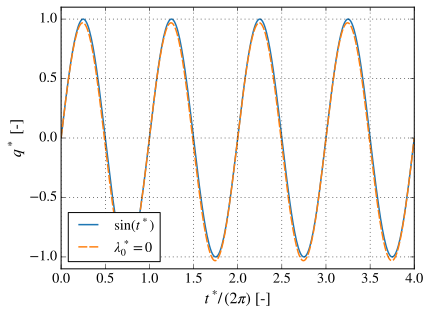

In [38]:
mpl.plot( ts_vec/twopi, np.sin(ts_vec), label="$\sin(t^*)$" )
mpl.plot( ts_vec/twopi, ys_lossless_vec[:,0], dashes=(9,2), label="$\lambda_0^*=0$" )
mpl.grid()
mpl.xlim( ( 0, 4 ) )
mpl.ylim( ( -1.1, 1.1 ) )
mpl.xlabel( '$t^*\!/\,(2\pi)$ [-]')
mpl.ylabel( '$q^*$ [-]')
mpl.legend( loc='lower left')
mpl.savefig( 'Frictionless_model.pdf', bbox_inches='tight', pad_inches=0.02);

# **Solution with channelbed friction and turbines thrust**

Turbine related parameters

In [7]:
C_T = 1.0       # thrust coefficient
C_P = 0.6436    # power coefficient

Aturb = 400.0   # area of 1 turbine [m^2] 
n_turbs = 24    # number of turbines [-]

B = n_turbs * Aturb / S  # blockage factor [-]
print( "B  = ", B )

λP = 0.5 * ρw * B * q0**3 / S**2 * C_P
print( "λP = %.2g W" % λP )

B  =  0.04
λP = 2.3e+08 W


In [8]:
λ0s = 0.5 * L * q0**2 / ( S**2 * h * g * a ) * f
print( "λ0s = %.4f" % λ0s )

λ1s = 0.5 * B * q0**2 / ( S**2 * g * a ) * C_T
print( "λ1s = %.4f" % λ1s )

# vector that stores the solution time series
ys_vec = np.zeros( ( num, 2 ) )

# solution of (Eq. 3) with "friction" terms
for i, ts in enumerate( ts_vec[1:] ):
  ys_vec[i+1] = ys_vec[i] + \
                       Delta_ts * fs( ys_vec[i], ts, λ0s, λ1s, n_turbs )

λ0s = 2.4813
λ1s = 0.0298


q_max^* = 0.53866
u_max   = 2.254 m/s


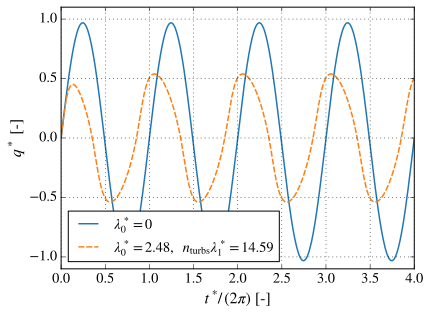

In [40]:
mpl.plot( ts_vec/twopi, ys_lossless_vec[:,0], label="$\lambda_0^*=0$" );
mpl.plot( ts_vec/twopi, ys_vec[:,0], label="$\lambda_0^*=%.2f,\ \ n_\mathrm{turbs}\lambda_1^*=%.2f$" % (λ0s,λ1s*n_turbs) )
mpl.grid()
mpl.xlim( ( 0, 4 ) )
mpl.ylim( ( -1.1, 1.1 ) )
mpl.xlabel( '$t^*\!/\,(2\pi)$ [-]')
mpl.ylabel( '$q^*$ [-]')
mpl.legend( loc='lower left')
mpl.savefig( 'Friction_model.pdf', bbox_inches='tight', pad_inches=0.02);

qmax = np.max(ys_vec[-ppp:,0])
umax = qmax * q0 / S

print( "q_max^* = %.5f" % qmax ) 
print( "u_max   = %.3f m/s" % umax )

Plot the energy of the last period

P^* = 1.694, Pt = 393.001 MW


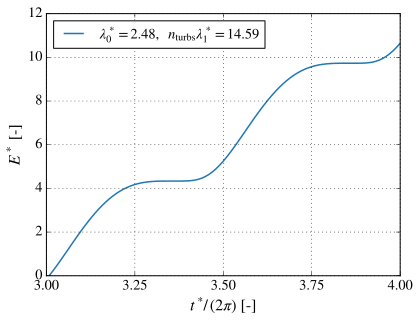

In [51]:


loc = plticker.MultipleLocator(base=0.25) # this locator puts ticks at regular intervals

es_last_period = ys_vec[-ppp:,1]    # data of the last period 
es_last_period -= es_last_period[0] # Zero energy at the begining of last period

Ps = es_last_period[-1] / (2*np.pi) # Time averaged converted power on last period (energy/period)    
print( "P^* = %.3f, Pt = %.3f MW" % ( Ps, Ps*λP/1E6 ) )

mpl.plot( ts_vec[-ppp:]/twopi, es_last_period, label="$\lambda_0^*=%.2f,\ \ n_\mathrm{turbs}\lambda_1^*=%.2f$" % (λ0s,λ1s*n_turbs) )
mpl.grid()
mpl.legend( loc = 'upper left')
mpl.xlim( ( 3, 4 ) )
mpl.gca().xaxis.set_major_locator(loc)
mpl.xlabel( '$t^*\!/\,(2\pi)$ [-]')
mpl.ylabel( '$E^*$ [-]')
mpl.savefig( 'Friction_model_Energy.pdf', bbox_inches='tight', pad_inches=0.02);

# **Plot the solution as function of the number of turbines**

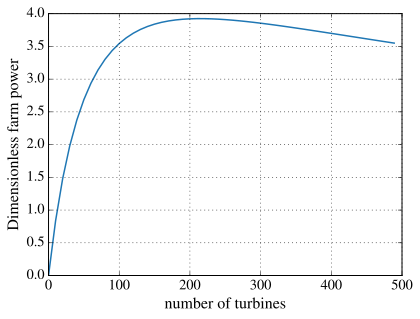

In [24]:
n_turbs_lst = range( 0, 500, 10 )    # number of turbines [-]
Ps_lst = []

ys1_vec = np.zeros( ( num, 2 ) )

for n_turbs in n_turbs_lst:

  # solution of (Eq. 3) with "friction" terms
  # the initial conditions are always (0,0)
  for i, ts in enumerate( ts_vec[1:] ):
    ys1_vec[i+1] = ys1_vec[i] + \
                        Delta_ts * fs( ys1_vec[i], ts, λ0s, λ1s, n_turbs )

  # last value of the last period minus the first value of the last period
  Ps = ( ys1_vec[-1,1] - ys1_vec[-ppp,1] )/ (2*np.pi)
  Ps_lst.append( Ps )
  
mpl.plot( n_turbs_lst, Ps_lst )
mpl.xlabel( r"number of turbines")
mpl.ylabel( r"Dimensionless farm power")
mpl.grid()
mpl.savefig( 'Friction_model_Power_nTurbines.pdf', bbox_inches='tight', pad_inches=0.02);